In [2]:
# ==============================================================
# Etapa 1: Identificación de la necesidad del negocio
# ==============================================================
# Pregunta: ¿Podemos predecir el precio de un inmueble en Bogotá a partir de sus características
# (área, habitaciones, baños, barrio, tipo), y segmentar el mercado en rangos de precios?

In [5]:

# ==============================================================
# Etapa 2: Selección del conjunto de datos
# ==============================================================

import pandas as pd

df = pd.read_csv("/content/inmuebles_bogota.csv")

print("Dimensiones iniciales:", df.shape)
print(df.head())



Dimensiones iniciales: (9520, 8)
          Tipo                                 Descripcion  Habitaciones  \
0  Apartamento  Apartamento en venta en Zona Noroccidental             3   
1         Casa                   Casa en venta en Castilla             4   
2  Apartamento     Apartamento en venta en Chico Reservado             3   
3  Apartamento             Apartamento en venta en Usaquén             3   
4  Apartamento         Apartamento en venta en Bella Suiza             2   

   Baños  Área              Barrio                                    UPZ  \
0      2    70  Zona Noroccidental     CHAPINERO: Pardo Rubio + Chapinero   
1      3   170            Castilla            KENNEDY: Castilla + Bavaria   
2      3   144     Chico Reservado     CHAPINERO: Chicó Lago + El Refugio   
3      2   154             Usaquén                                Usaquén   
4      3   128         Bella Suiza  USAQUÉN: Country Club + Santa Bárbara   

             Valor  
0    $ 360.000.000  
1    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9520 entries, 0 to 9519
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tipo          9520 non-null   object
 1   Descripcion   9520 non-null   object
 2   Habitaciones  9520 non-null   int64 
 3   Baños         9520 non-null   int64 
 4   Área          9520 non-null   int64 
 5   Barrio        9520 non-null   object
 6   UPZ           9478 non-null   object
 7   Valor         9520 non-null   object
dtypes: int64(3), object(5)
memory usage: 595.1+ KB
               Tipo                      Descripcion  Habitaciones  \
count          9520                             9520   9520.000000   
unique            8                              316           NaN   
top     Apartamento  Apartamento en venta en Usaquén           NaN   
freq           7327                              916           NaN   
mean            NaN                              NaN      3.072479   
st

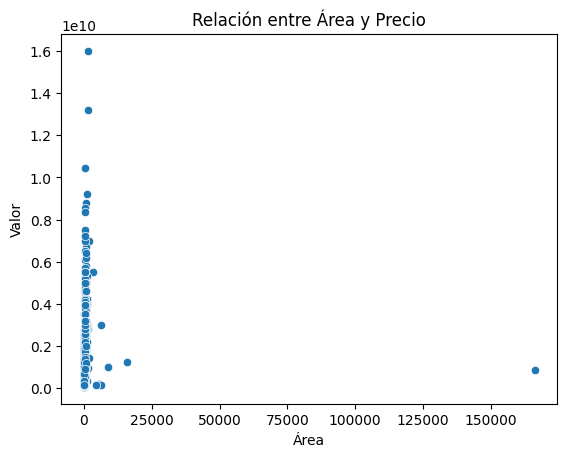

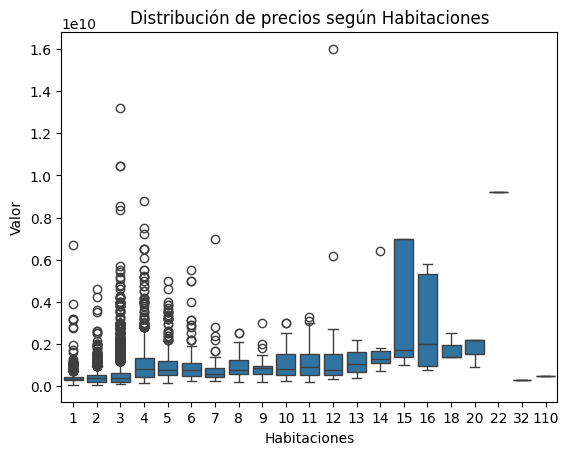

In [6]:
# ==============================================================
# Etapa 3: Exploración de los datos
# ==============================================================

import matplotlib.pyplot as plt
import seaborn as sns

df.info()
print(df.describe(include="all"))
print("Valores nulos por columna:\n", df.isnull().sum())

# Limpieza inicial: convertir Valor a numérico
df["Valor"] = df["Valor"].str.replace("$", "", regex=False).str.replace(".", "", regex=False)
df["Valor"] = pd.to_numeric(df["Valor"], errors="coerce")

# Gráficos exploratorios
sns.scatterplot(x="Área", y="Valor", data=df)
plt.title("Relación entre Área y Precio")
plt.show()

sns.boxplot(x="Habitaciones", y="Valor", data=df)
plt.title("Distribución de precios según Habitaciones")
plt.show()




In [7]:
# ==============================================================
# Etapa 4: Preprocesamiento de los datos
# ==============================================================

# Eliminar nulos
df = df.dropna(subset=["Valor", "Área", "Habitaciones", "Baños"])

# Filtrar outliers extremos
df = df[(df["Área"] < 1000) & (df["Habitaciones"] <= 10) & (df["Valor"] < 5e9)]

# Transformar variable dependiente (log)
import numpy as np
df["LogValor"] = np.log1p(df["Valor"])

# One-Hot Encoding para variables categóricas
df = pd.get_dummies(df, columns=["Barrio", "UPZ", "Tipo"], drop_first=True)

# Variables independientes (X) y dependiente (y)
X = df.drop(columns=["Valor", "LogValor", "Descripcion"])  # quitamos también 'Descripcion'
y = df["LogValor"]




Modelo: Regresión Lineal
MAE (COP): 177,650,139
RMSE (COP): 533,982,535
R²: 0.792

Modelo: Random Forest
MAE (COP): 94,934,071
RMSE (COP): 209,364,326
R²: 0.913


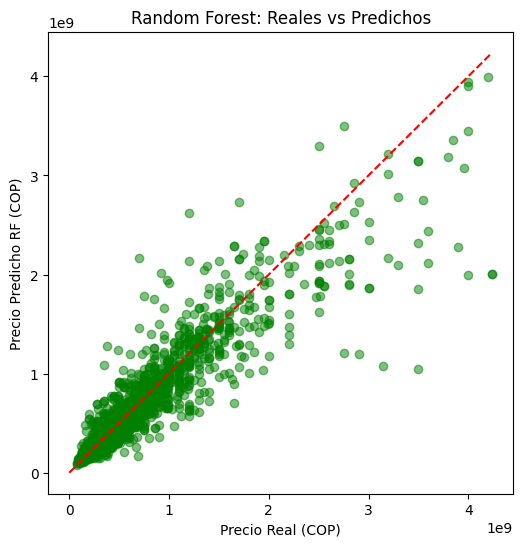

In [8]:
# ==============================================================
# Etapa 5: Modelado y Comparación
# ==============================================================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---- Modelo Lineal ----
modelo_lin = LinearRegression()
modelo_lin.fit(X_train, y_train)
y_pred_lin = modelo_lin.predict(X_test)

# ---- Random Forest ----
modelo_rf = RandomForestRegressor(n_estimators=200, random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

# Función para métricas
def evaluar(y_real, y_pred, nombre):
    mae = mean_absolute_error(np.expm1(y_real), np.expm1(y_pred))
    rmse = np.sqrt(mean_squared_error(np.expm1(y_real), np.expm1(y_pred)))
    r2 = r2_score(y_real, y_pred)
    print(f"\nModelo: {nombre}")
    print(f"MAE (COP): {mae:,.0f}")
    print(f"RMSE (COP): {rmse:,.0f}")
    print(f"R²: {r2:.3f}")

# Evaluación
evaluar(y_test, y_pred_lin, "Regresión Lineal")
evaluar(y_test, y_pred_rf, "Random Forest")

# Comparación visual
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred_rf), alpha=0.5, color="green")
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], "r--")
plt.xlabel("Precio Real (COP)")
plt.ylabel("Precio Predicho RF (COP)")
plt.title("Random Forest: Reales vs Predichos")
plt.show()



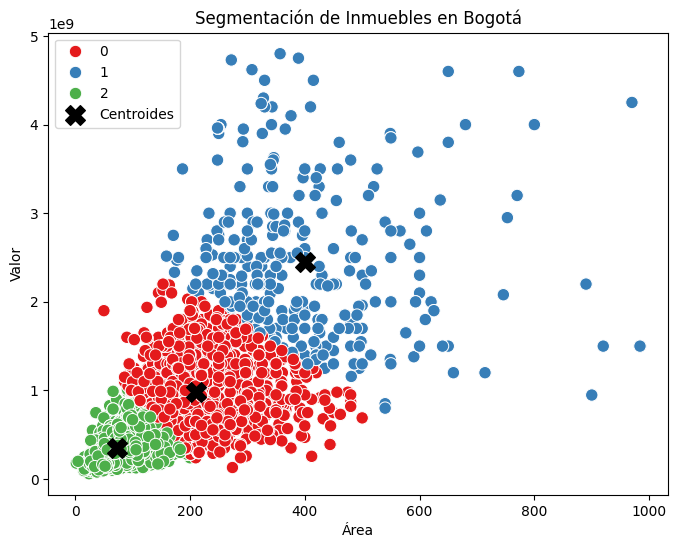

In [9]:
# ==============================================================
# Etapa 6: Interpretación y evaluación
# ==============================================================
# - El modelo lineal muestra limitaciones (coeficientes poco interpretables por multicolinealidad).
# - Random Forest mejora las predicciones y maneja mejor la no linealidad.
# - MAE nos da un error promedio interpretable en COP.
# - Transformar el target con log ayuda a estabilizar varianza y manejar mejor precios altos.

# ==============================================================
# Aprendizaje No Supervisado (Clustering)
# ==============================================================

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X_cluster = df[["Área", "Valor"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x="Área", y="Valor", hue="Cluster", data=df, palette="Set1", s=80)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], s=200, c="black", marker="X", label="Centroides")
plt.title("Segmentación de Inmuebles en Bogotá")
plt.legend()
plt.show()



# ==============================================================
# Conclusiones esperadas
# ==============================================================
# 1. La limpieza de outliers mejora la calidad del modelo.
# 2. Random Forest supera al modelo lineal en métricas (MAE, RMSE).
# 3. La transformación log reduce el sesgo por precios extremadamente altos.
# 4. Variables categóricas (barrio, UPZ) aportan al poder predictivo.
# 5. Clustering muestra rangos de mercado (económico, medio, premium).